## Klasifikasi Binary sederhana

Kali ini kita akan mengklasifikasikan sebuah koordinat (x, y) apakah koordinat tersebut merupakan bagian dari lingkaran luar (merah) atau dalam (biru).

In [1]:
# import library yang diperlukan
import torch
import torch.nn as nn
from torchmetrics import Accuracy
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# kita generate 1000 koordinat dan labelnya dengan fungsi `make_circles` dari sklearn.
# NB: noise=0.03 artinya kita ingin setiap koordinat sedikit acak, jadi tidak berkumpul di satu titik saja.
coordinates, types = make_circles(1000, random_state=42, noise=0.05)

In [3]:
coordinates[:10]

array([[ 0.74220688,  0.24668576],
       [-0.7340323 ,  0.16869164],
       [-0.82985872,  0.22195899],
       [-0.42913559,  0.67223019],
       [ 0.44560223, -0.89493556],
       [-0.46988549,  0.70803745],
       [-0.01604538,  0.80562331],
       [ 0.75962295,  0.15952616],
       [-0.17569191, -0.79983689],
       [-0.11061613,  1.04220747]])

In [4]:
# type atau labelnya berupa angka 1 (lingkaran dalam) atau 0 (lingkaran luar)
# yang cocok untuk binary classification problem.
types[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

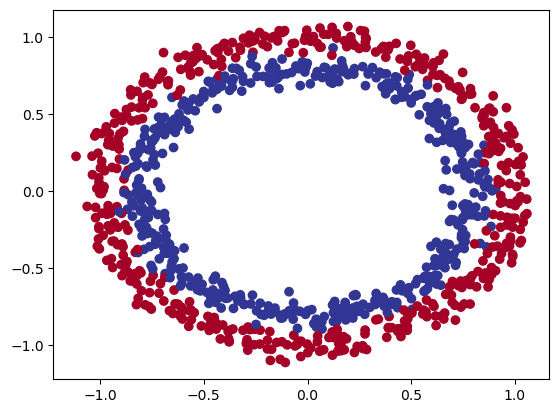

In [5]:
# tampilkan dataset kita
plt.scatter(
    x=coordinates[:, 0],
    y=coordinates[:, 1],
    c=types,
    cmap=plt.cm.RdYlBu
)

In [6]:
# konversi koordinat dan type diatas menjadi Tensor
X = torch.tensor(coordinates, dtype=torch.float)
y = torch.tensor(types, dtype=torch.float).unsqueeze(dim=1) # kita sesuaikan dimensinya (shape)

In [7]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [8]:
# buat dataset training dan test menggunakan fungsi `train_test_split` dari sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# buat modelnya
class CircleClassification(nn.Module):
    def __init__(self):
        """
        Disini kita membuat sebuah model dengan memadukan 2 buah Linear layer dan satu buah ReLu.
        layer1 menerima 2 input (koordinat x dan y), dan memiliki 8 output.
        layer2 menerima 8 input dan hanya memiliki 1 output (prediksi antara: lingkaran luar atau lingkaran dalam)
    
        ReLU (Rectified Linear Unit), ini diperlukan karena model juga perlu membaca pola yang tidak linear (lurus),
        koordinat kita membentuk dua buah lingkaran maka perlu layer yang bisa membaca pola tersebut.
        """
        super().__init__()
        
        self.l1 = nn.Linear(in_features=2, out_features=8)
        self.l2 = nn.Linear(in_features=8, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.l1(x)) # ReLU kita aplikasikan ke layer1 saja.
        x = self.l2(x)
        return x

In [10]:
# Inisiasi model, loss function dan optimizer
torch.manual_seed(42)

model = CircleClassification()
loss_fn = nn.BCEWithLogitsLoss() # Binary Cross Entropy with logits
optim = torch.optim.Adam(model.parameters(), lr=0.1)
acc_fn = Accuracy(task="binary")

# training loop
epochs = 200
losses = []

for i in range(epochs):
    model.train()
    
    # output mentah dari model adalah `logits` bukan 1 atau 0
    y_logits = model(X_train)
    
    loss = loss_fn(y_logits, y_train)
    losses.append(loss.item())
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    model.eval()
    
    # hitung akurasi:
    # "Akurasi" adalah persentase prediksi yang benar dari semua prediksi, semakin besar semakin akurat.
    
    # konversi logits menjadi 1 atau 0 sehingga bisa digunakan untuk menghitung akurasi
    y_pred = torch.round(torch.sigmoid(y_logits))
    acc = acc_fn(y_pred, y_train)
    
    if i%10==0:
        print(f"epoch={i+1}, loss={loss}, accuracy: {acc.item()}")

epoch=1, loss=0.6972710490226746, accuracy: 0.48875001072883606
epoch=11, loss=0.6384313702583313, accuracy: 0.7612500190734863
epoch=21, loss=0.5063221454620361, accuracy: 0.9037500023841858
epoch=31, loss=0.34371671080589294, accuracy: 0.96875
epoch=41, loss=0.22796659171581268, accuracy: 0.9649999737739563
epoch=51, loss=0.16751065850257874, accuracy: 0.9599999785423279
epoch=61, loss=0.13223209977149963, accuracy: 0.9712499976158142
epoch=71, loss=0.10815738886594772, accuracy: 0.9712499976158142
epoch=81, loss=0.09096696972846985, accuracy: 0.9787499904632568
epoch=91, loss=0.07849548757076263, accuracy: 0.981249988079071
epoch=101, loss=0.07153898477554321, accuracy: 0.9787499904632568
epoch=111, loss=0.06606955826282501, accuracy: 0.9800000190734863
epoch=121, loss=0.060403987765312195, accuracy: 0.9837499856948853
epoch=131, loss=0.05680191516876221, accuracy: 0.9850000143051147
epoch=141, loss=0.05351157486438751, accuracy: 0.9837499856948853
epoch=151, loss=0.0509546473622322

Text(0, 0.5, 'losse')

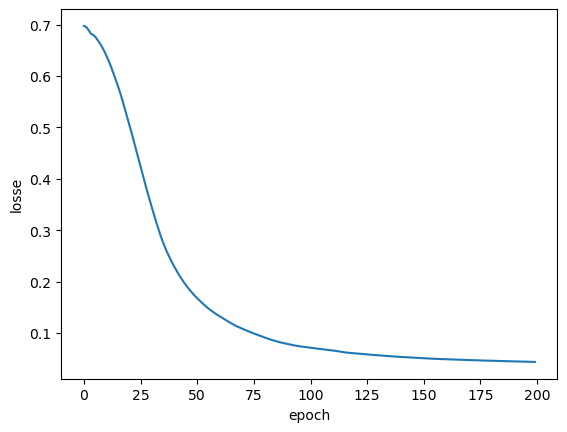

In [11]:
# Wow! loss langsung mendekati nol dan akurasi 0.98 alias 98% hanya dengan 200 epochs.

# kita visualisasikan lossnya
plt.plot(range(epochs), losses)
plt.xlabel("epoch")
plt.ylabel("losse")

In [12]:
# Sekarang kita coba cek akurasi pada dataset test.

with torch.inference_mode():
    y_logits = model(X_test)
    
    y_pred = torch.round(torch.sigmoid(y_logits))
    print(f"Akurasi: {acc_fn(y_pred, y_test)}")

Akurasi: 0.9350000023841858


Ternyata ketika digunakan untuk memprediksi label pada dataset Test pun akurasinya cukup bagus yaitu 93%.

⚠️ **Ketika dihadapkan dengan model di kehidupan nyata, maka sangat susah untuk mencapai akurasi 100%.**

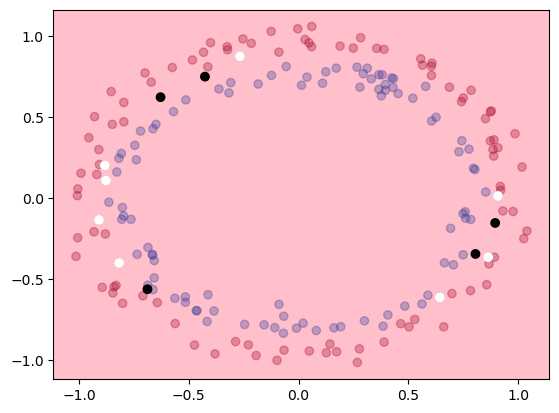

In [13]:
# coba kita tampilkan koordinat yang salah diprediksi
equals = torch.eq(y_pred, y_test)
indices = (equals == False).nonzero()[:, 0]

X_wrong_predictions = torch.index_select(X_test, 0, indices)
y_wrong_predictions = torch.index_select(y_pred, 0, indices)

# mari kita plot koordinat test vs. yang salah prediksi.
ax = plt.axes()
ax.set_facecolor("pink")
plt.scatter(
    x=X_test[:, 0],
    y=X_test[:, 1],
    c=y_test,
    cmap=plt.cm.RdYlBu,
    alpha=0.3
)
plt.scatter(
    x=X_wrong_predictions[:, 0],
    y=X_wrong_predictions[:, 1],
    c=y_wrong_predictions,
    cmap=plt.cm.Greys
)

**Terlihat titik putih dan hitam adalah koordinat yang salah diprediksi, kalau diperhatikan posisi mereka berada diantara kedua lingkaran sehingga model mengalami kesulitan mengklasifikasikan mereka (apakah mereka bagian dari lingkaran luar atau dalam).**